In [1]:
import import_ipynb
import Scanpy_functions_v03262021 as sc_pipe
import scvelo as scv
scv.logging.print_version()
import warnings
import scirpy as ir
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import bbknn
import logging
from sklearn.mixture import GaussianMixture
from scipy.stats     import norm
import glob
import os
import hvplot.pandas
import docx
from docx import Document
from docx.shared import Inches
from docx.shared import Pt
from scipy import sparse
import scanpy.external as sce
import holoviews as hv
import panel as pn
import bokeh
from bokeh.resources import INLINE
import scanorama
import gseapy

importing Jupyter notebook from Scanpy_functions_v03262021.ipynb
Running scvelo 0.2.3 (python 3.8.5) on 2022-01-26 21:47.
Running scvelo 0.2.3 (python 3.8.5) on 2022-01-26 21:48.


In [2]:
# define sample metadata. Usually read from a file.
exclude_genes = ['Rpl', 'Rps', 'Trav', 'Traj', 'Trbj', 'Trbv','Mrp','Fau','Dap3','Uba52','Ighv', 'Igkv', 'Iglv']


In_path = '/user/ifrec/liuyuchen/scRNASeq_DATA/Akira_Fukusima_scRNASeq/'

out_path = '/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq/'

In [3]:
#sc.set_figure_params(scanpy=True, dpi=200,  figsize=[12.8,9.6])
sc.settings.verbosity = 3

In [4]:
human = sc.read_h5ad('/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq/human/human_requested_samples.h5ad')
mouse = sc.read_h5ad('/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq/mouse/mouse_merged.h5ad')

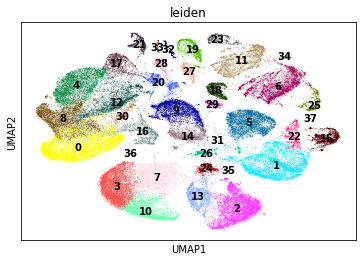

In [5]:
sc.pl.umap(mouse,color='leiden',legend_loc='on data')

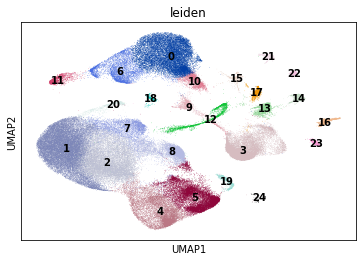

In [6]:
sc.pl.umap(human,color='leiden',legend_loc='on data')

In [7]:
mouse.obs['SatM_like'] ='NA'
mouse.obs.loc[mouse.obs['leiden'].isin(['9','14']),'SatM_like'] =  'SatM_like'

... storing 'SatM_like' as categorical


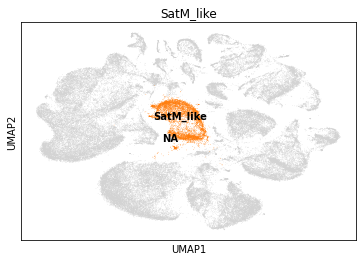

In [8]:
sc.pl.umap(mouse,color='SatM_like',groups=[ 'SatM_like'],legend_loc='on data')

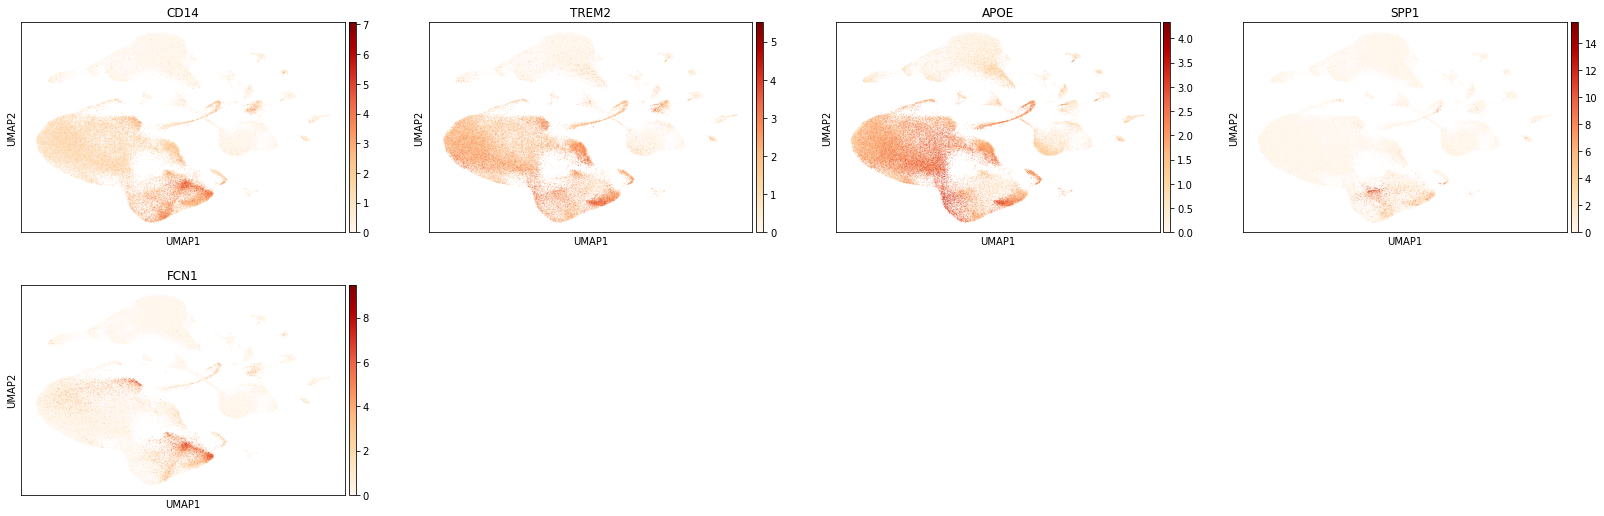

In [10]:
sc.pl.umap(human,color=['CD14','TREM2','APOE','SPP1','FCN1'],use_raw=False,cmap='OrRd')

In [11]:
human.obs['Selected_group'] ='NA'
human.obs.loc[human.obs['leiden'].isin(['4']),'Selected_group'] =  'FMF macrophage'
human.obs.loc[human.obs['leiden'].isin(['5']),'Selected_group'] =  'FCN1 high macrophage'

... storing 'Selected_group' as categorical


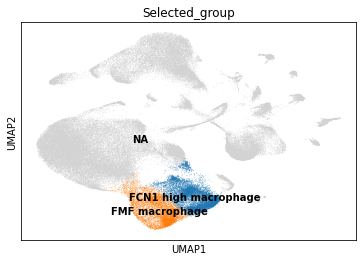

In [12]:
sc.pl.umap(human,color='Selected_group',groups=[ 'FMF macrophage','FCN1 high macrophage'],legend_loc='on data')

In [14]:

ad_ref = mouse.copy()
ad_ingest = human.copy()
ad_ref.var_names=ad_ref.var_names.str.upper()



In [17]:
ad_ref.X

<93597x14332 sparse matrix of type '<class 'numpy.float32'>'
	with 96094840 stored elements in Compressed Sparse Row format>

In [20]:
sc.pp.pca(ad_ref)
sc.pp.neighbors(ad_ref)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)


In [21]:
var_names = ad_ref.var_names.intersection(ad_ingest.var_names)
ad_ref = ad_ref[:, var_names]
ad_ingest= ad_ingest[:, var_names]
sc.tl.ingest(ad_ingest, ad_ref, obs='SatM_like')


running ingest
    finished (0:01:58)


NameError: name 'adata' is not defined

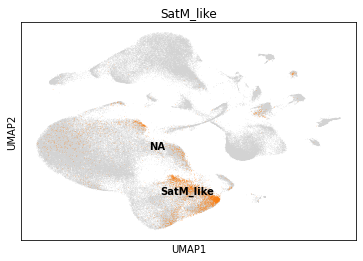

In [22]:
human.obs  = ad_ingest.obs
sc.pl.umap(human,color='SatM_like',groups=[ 'SatM_like'],legend_loc='on data')

In [38]:
ad_ref.obs['mouse_clusters'] = ad_ref.obs['leiden']
ad_ingest.obs['human_clusters'] = ad_ingest.obs['leiden']
del ad_ref.obs['leiden']
del ad_ingest.obs['leiden']

Trying to set attribute `.obs` of view, copying.


... storing 'Sample' as categorical
... storing 'Conditions' as categorical
... storing 'Organ' as categorical
... storing 'Cell_Type' as categorical
... storing 'mouse_clusters' as categorical
... storing 'condition' as categorical
... storing 'Selected_group' as categorical
... storing 'human_clusters' as categorical


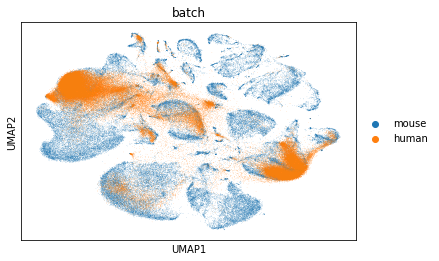

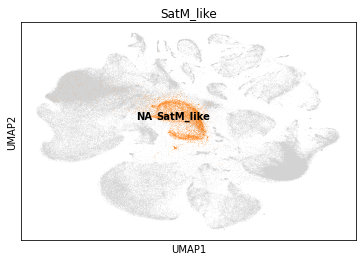

In [39]:
adata_concat = ad_ref.concatenate(ad_ingest, batch_categories=['mouse', 'human'])
sc.pl.umap(adata_concat, color='batch')
sc.pl.umap(adata_concat, color='SatM_like',groups=[ 'SatM_like'],legend_loc='on data')

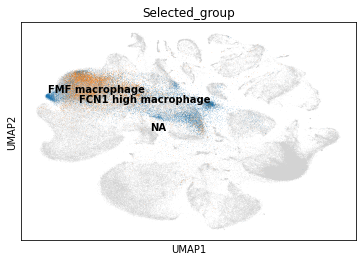

In [40]:
sc.pl.umap(adata_concat,color='Selected_group',groups=[ 'FMF macrophage','FCN1 high macrophage'],legend_loc='on data')

In [33]:
macros =[]
for x in mouse.obs.Cell_Type.unique().tolist():
    if 'Macro' in str(x):
        macros.append(x)

In [34]:
macros

['Macrophage', 'Proliferating Macrophage']

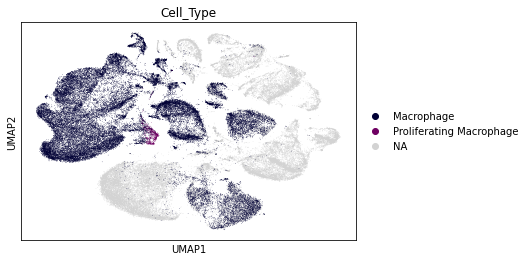

In [35]:
sc.pl.umap(mouse,color='Cell_Type', groups=macros)

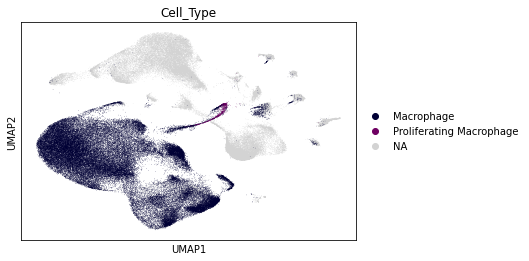

In [36]:
sc.pl.umap(human,color='Cell_Type', groups=macros)

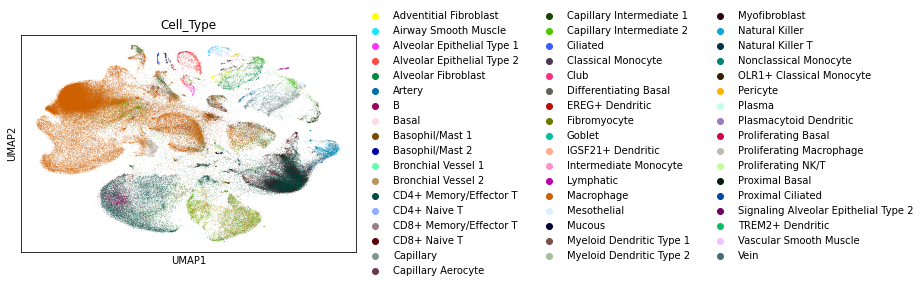

In [41]:
sc.pl.umap(adata_concat,color='Cell_Type')

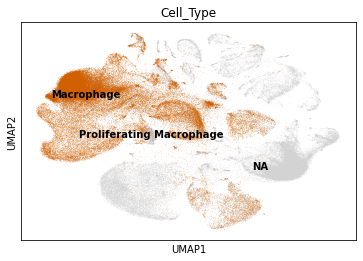

In [42]:
sc.pl.umap(adata_concat,color='Cell_Type',groups=macros,legend_loc='on data')

In [26]:
human.write_h5ad(out_path+'/human_ingested_label.h5ad')

In [27]:
mouse.write_h5ad(out_path+'/mouse_labeled.h5ad')

In [43]:
adata_concat.write_h5ad(out_path+'/mapping_human_cells_onto_mouse.h5ad')

In [28]:
from pyBCS import scanpy2bcs
scanpy2bcs.format_data(out_path+'/human_ingested_label.h5ad', out_path+'/human_label_ingested.bcs',
                        input_format="h5ad", graph_based="leiden")

Writing main/metadata/metalist.json
Cannot convert Sample to numeric, treating as categorical
Cannot convert leiden to numeric, treating as categorical
Cannot convert Cell_Type to numeric, treating as categorical
Cannot convert condition to numeric, treating as categorical
Cannot convert Selected_group to numeric, treating as categorical
Cannot convert SatM_like to numeric, treating as categorical
"predicted_doublet" is not numeric or categorical, ignoring
Found graph based clustering in metadata with keyword leiden
Writing main/metadata/05d568a1064341818d3fcf05c8949e16.json
Writing main/metadata/7e06d959130642c7be04e13dd4125dcb.json
Writing main/metadata/f32f7b4207c648c0bf583ce76beaeca7.json
Writing main/metadata/61af31cde5954c73851bf9f305953c23.json
Writing main/metadata/133ca2a891c64862b7e2b7d19de416de.json
Writing main/metadata/0dca36318cc9405790ce677f73538f77.json
Writing main/metadata/e742dd85d34845ad9db9544da2ca43ad.json
Writing main/metadata/b51136549c2e4abc8f1eec8b58178283.jso

'/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq//human_label_ingested.bcs'

In [29]:
scanpy2bcs.format_data(out_path+'/mouse_labeled.h5ad', out_path+'/mouse_labeled.bcs',
                        input_format="h5ad", graph_based="leiden")

Writing main/metadata/metalist.json
Cannot convert Sample to numeric, treating as categorical
Cannot convert leiden to numeric, treating as categorical
Cannot convert Conditions to numeric, treating as categorical
Cannot convert Organ to numeric, treating as categorical
Cannot convert Cell_Type to numeric, treating as categorical
Cannot convert SatM_like to numeric, treating as categorical
"predicted_doublet" is not numeric or categorical, ignoring
Found graph based clustering in metadata with keyword leiden
Writing main/metadata/ae9491b1c666459c8a0fd0395e262137.json
Writing main/metadata/b01530317b4142ae9242d8a335de3d5a.json
Writing main/metadata/1a15e0cee5244e18849b0aefc270c523.json
Writing main/metadata/c97d71b039a24ef085201fa69f56f156.json
Writing main/metadata/be9dc76c2a4a4c618e4f7f74bcaa10f7.json
Writing main/metadata/c79402876a9540b1af89f85db6649e31.json
Writing main/metadata/4cfeef41740242ef88eb2752e0bd9a58.json
Writing main/metadata/bf1d4ba566a34c04b413aace86e04ba8.json
Writin

'/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq//mouse_labeled.bcs'

In [44]:
scanpy2bcs.format_data(out_path+'/mapping_human_cells_onto_mouse.h5ad', out_path+'/mapping_human_cells_onto_mouse.bcs',
                        input_format="h5ad", graph_based="leiden")

Writing main/metadata/metalist.json
Cannot convert Sample to numeric, treating as categorical
Cannot convert batch to numeric, treating as categorical
Cannot convert Conditions to numeric, treating as categorical
Cannot convert Organ to numeric, treating as categorical
Cannot convert Cell_Type to numeric, treating as categorical
Cannot convert SatM_like to numeric, treating as categorical
Cannot convert condition to numeric, treating as categorical
Cannot convert Selected_group to numeric, treating as categorical
"predicted_doublet" is not numeric or categorical, ignoring
Cannot find graph based clustering in metadata with keyword "leiden", generating a fake one
Writing main/metadata/c2bb96de95b34b42a01a0eeb20d40181.json
Writing main/metadata/7039505da0c74b1390bb990579931fa7.json
Writing main/metadata/83c4ddfdbdda497bb0b5b6e86c2bd056.json
Writing main/metadata/87d89a08b95c49ff95c3e63283204408.json
Writing main/metadata/90498f25f98249dabda85cef921ec6f1.json
Writing main/metadata/f5f340a

'/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq//mapping_human_cells_onto_mouse.bcs'